In [51]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from matplotlib.colors import LogNorm
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import numpy as np


In [52]:
def plot_gaussian_mixture(clusterer, X, anomalies=None, resolution=500, marker_size=10):
    mins = X.min(axis=0) - 0.5
    maxs = X.max(axis=0) + 0.5
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=50.0),
                 levels=np.logspace(0, 2, 12), cmap='Spectral')
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=50.0),
                levels=np.logspace(0, 2, 12), linewidths=1, colors='k')
    Z_pred = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_pred = Z_pred.reshape(xx.shape)
    plt.contour(xx, yy, Z_pred, linewidths=2, colors='white', linestyles='dashed')
    plt.plot(X[:, 0], X[:, 1], 'o', markersize=marker_size, color='gray', alpha=0.5)
    for i in range(len(clusterer.means_)):
        plt.plot(clusterer.means_[i][0], clusterer.means_[i][1], 'o', markersize=15,
                 markeredgecolor='black', markerfacecolor='yellow', label=f"Cluster {i} centroid")
    for i in range(len(clusterer.means_)):
        plt.text(clusterer.means_[i][0], clusterer.means_[i][1], f"Weight: {clusterer.weights_[i]:.2f}",
                 color='black', fontsize=14, ha='center', va='center')
    if anomalies is not None and len(anomalies) > 0:
        plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='*', s=200, label='Outliers')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", rotation=0, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [53]:
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=60)


In [54]:
model = GaussianMixture(n_components=3, covariance_type='full', random_state=60)
model.fit(X)

C:\Users\marce\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


GaussianMixture(n_components=3, random_state=60)

In [55]:
densities = model.score_samples(X)
density_threshold = np.percentile(densities, 4)  
anomalies = X[densities < density_threshold]

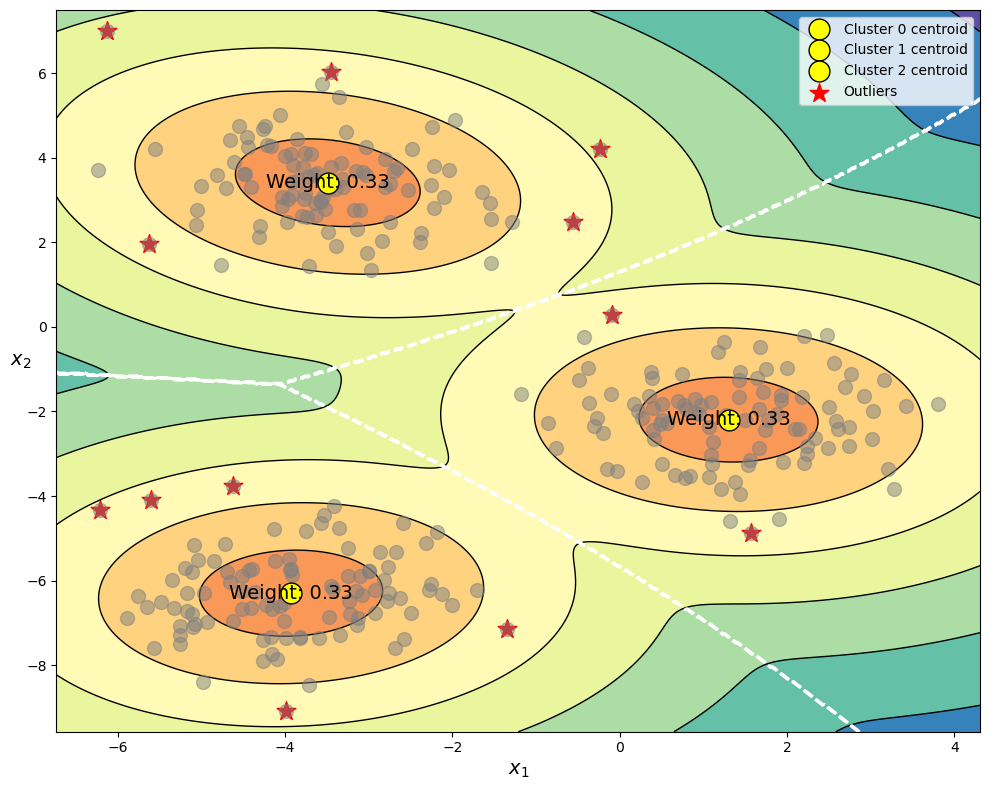

In [56]:
plt.figure(figsize=(10, 8))
plot_gaussian_mixture(model, X, anomalies)

In [57]:
X_cleaned = X[densities >= density_threshold]
model_cleaned = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
model_cleaned.fit(X_cleaned)

C:\Users\marce\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


GaussianMixture(n_components=3, random_state=42)

Gaussian Mixture Model after Manual Removal of Outliers


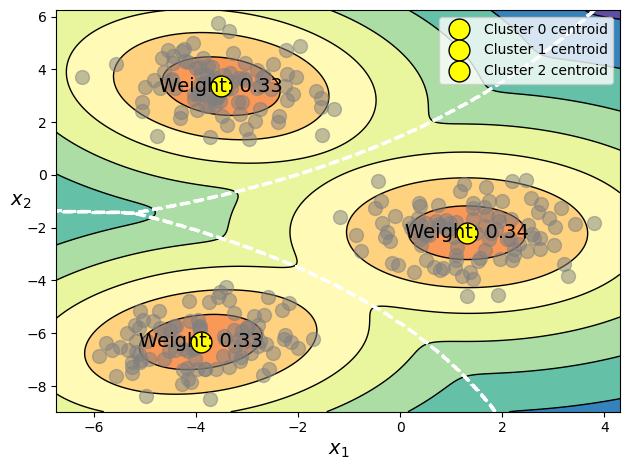

In [58]:
print("Gaussian Mixture Model after Manual Removal of Outliers")
plot_gaussian_mixture(model_cleaned, X_cleaned, anomalies=None)

In [59]:
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=60)

C:\Users\marce\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Gaussian Mixture Model after Cleaning with EllipticEnvelope


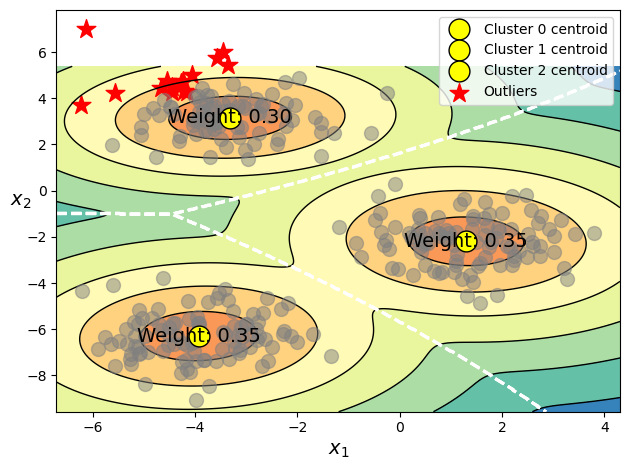

In [60]:
elliptic_env = EllipticEnvelope(contamination=0.05, random_state=60)
elliptic_env.fit(X)
inliers = elliptic_env.predict(X) == 1

X_robust_cleaned = X[inliers]
model_robust_cleaned = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
model_robust_cleaned.fit(X_robust_cleaned)

anomalies_robust = X[~inliers]
print("Gaussian Mixture Model after Cleaning with EllipticEnvelope")
plot_gaussian_mixture(model_robust_cleaned, X_robust_cleaned, anomalies=anomalies_robust)


In [61]:
print(f"Number of inliers: {len(X_robust_cleaned)}")
print(f"Number of outliers: {len(anomalies_robust)}")


Number of inliers: 285
Number of outliers: 15


In [62]:
n_features = X_robust_cleaned.shape[1]
n_components = model_robust_cleaned.n_components
n_params = n_components * (n_features + 1) + n_components * n_features * (n_features + 1) / 2 - 1


In [63]:
n_samples = X_robust_cleaned.shape[0]
log_likelihood = model_robust_cleaned.score(X_robust_cleaned) * n_samples


In [64]:
aic_manual = 2 * n_params - 2 * log_likelihood
bic_manual = n_params * np.log(n_samples) - 2 * log_likelihood


In [65]:
aic_builtin = model_robust_cleaned.aic(X_robust_cleaned)
bic_builtin = model_robust_cleaned.bic(X_robust_cleaned)


In [66]:
print("Manual AIC:", aic_manual)
print("Built-in AIC:", aic_builtin)
print("Manual BIC:", bic_manual)
print("Built-in BIC:", bic_builtin)

Manual AIC: 2255.361040011421
Built-in AIC: 2255.361040011421
Manual BIC: 2317.4533560759883
Built-in BIC: 2317.4533560759883


In [70]:
model_bayesian_gmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=60)
model_bayesian_gmm.fit(X)

C:\Users\marce\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


BayesianGaussianMixture(n_components=10, random_state=60)

In [71]:
print("Means of the components:")
print(model_bayesian_gmm.means_)
print("\nCovariances of the components:")
print(model_bayesian_gmm.covariances_)
print("\nWeights of the components:")
print(model_bayesian_gmm.weights_)


Means of the components:
[[-3.47329023  3.35956268]
 [-2.02267773 -1.67754314]
 [-2.02276686 -1.6776359 ]
 [ 1.26785246 -2.18889411]
 [-2.02303062 -1.67791018]
 [-2.02320362 -1.67808989]
 [-3.90759397 -6.25247996]
 [-2.03826365 -1.69318598]
 [-2.03826425 -1.69318655]
 [-2.03826425 -1.69318656]]

Covariances of the components:
[[[ 1.1855342  -0.27957282]
  [-0.27957282  1.39003582]]

 [[ 3.39031647 -0.07447995]
  [-0.07447995  8.51566489]]

 [[ 3.39025609 -0.07460157]
  [-0.07460157  8.51524646]]

 [[ 1.31075488 -0.06902298]
  [-0.06902298  1.16479474]]

 [[ 3.3900773  -0.07496147]
  [-0.07496147  8.51400812]]

 [[ 3.38995995 -0.07519753]
  [-0.07519753  8.51319589]]

 [[ 1.20084654  0.14400511]
  [ 0.14400511  1.32388441]]

 [[ 3.37948535 -0.09575789]
  [-0.09575789  8.44236299]]

 [[ 3.37948492 -0.0957587 ]
  [-0.0957587   8.44236018]]

 [[ 3.37948492 -0.09575871]
  [-0.09575871  8.44236018]]]

Weights of the components:
[3.35414645e-01 3.41732604e-03 3.39968958e-03 3.30147548e-01
 3.

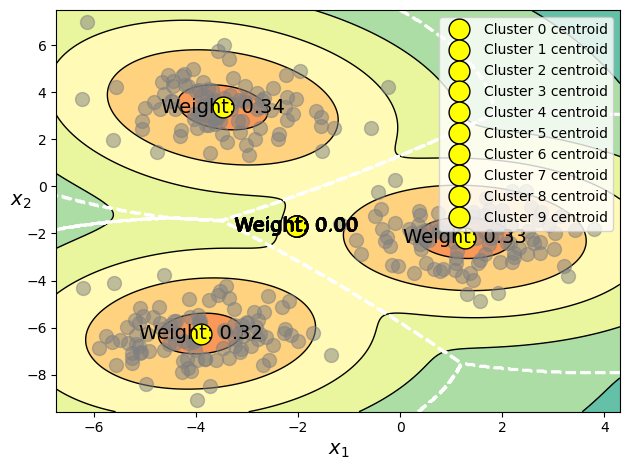

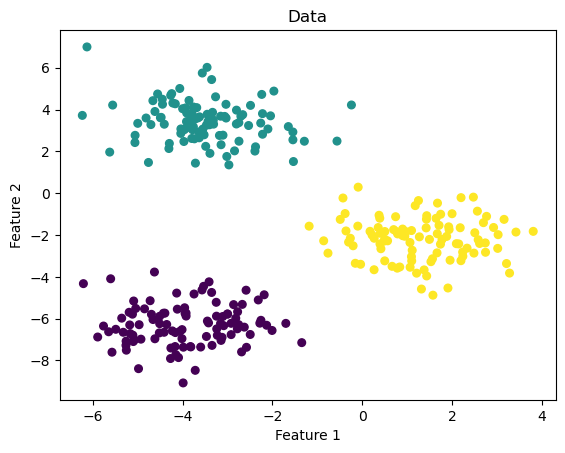

In [72]:
y_pred_bayesian_gmm = model_bayesian_gmm.predict(X)
plot_gaussian_mixture(model_bayesian_gmm, X)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30)
plt.title("Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()